### prerequisite

In [ ]:
# =============================================
# IMPORT LIBRARIES
# =============================================

import numpy as np
import pandas as pd
import os
os.chdir('..')
import pickle
import json
# import math

from citations_lib.create_fig_helper_functions import *
from citations_lib.utils import *
from citations_lib.author_vs_group_layout import *
from citations_lib.group_vs_group_layout import *
from citations_lib.author_vs_author_layout import *
from citations_lib.metric_tab_layout import *

import dash
import dash.html as html
import dash_leaflet as dl
from jupyter_dash import JupyterDash
#from dash_extensions.javascript import arrow_function, assign, Namespace
import country_converter as coco
cc = coco.CountryConverter()

# ======================a=======================
# Data Preparation
# =============================================

dfs_career, dfs_singleyr, dfs_career_log, dfs_singleyr_log, dfs_career_text, dfs_singleyr_text, dfs_career_yrs, dfs_singleyr_yrs = load_standardized_data()

darkAccent1 = '#2C2C2C' # dark gray
darkAccent2 = '#5b5959' # pale gray
darkAccent3 = '#CFCFCF' # almost white
lightAccent1 = '#ECAB4C' # ocre
highlight1 = 'lightsteelblue'
highlight2 = 'cornflowerblue'
theme =  {
    'dark': True,
    'detail': lightAccent1,
    'primary': darkAccent1,
    'secondary': lightAccent1
}

g1c = [highlight1, darkAccent2] # bar plot bars 1 & 2
g2c = [highlight2, darkAccent3] # bar plot bar 3
bgc = darkAccent1 # bar plot background

### TEST ZONE

### TEST ZONE 2

In [ ]:
def create_geo_json(df_in, df_in_log,career, yr, metric, color_by = 'count',logTransf = False, empty = False):
    '''
    Heavily inspired by Thibaud Lamothe tutorial here: https://towardsdatascience.com/how-to-create-outstanding-custom-choropleth-maps-with-plotly-and-dash-49ac918a5f05
    data/custom.geo.json was generated here: https://geojson-maps.ash.ms/

    options for color_by: 
        'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'count_log', 'mean_log',
        'std_log', 'min_log', '25%_log', '50%_log', '75%_log', 'max_log'
    '''

    # === Creating country df ===
    cc = coco.CountryConverter()
    country_df = df_in.groupby('cntry')[metric].describe()
    country_df_log = df_in_log.groupby('cntry')[metric].describe()
    country_df_log.columns = [item + '_log' for item in country_df_log.columns]
    country_df = country_df.join(country_df_log)
    country_df['CODE'] = country_df.index #[i for i in country_df.index]
    if 'csk' in country_df.index: country_df = country_df.drop(['csk']) # Czekoslovakia – unclear if that uni is in Czech Republic or Slovakia!
    if 'nan' in country_df.index: country_df = country_df.drop(['nan'])
    names = []
    for cntry in list(country_df['CODE']):
        if str(cntry) == 'sux': names.append('Russia')
        elif str(cntry) == 'ant': names.append('Netherlands')
        elif str(cntry) == 'scg': names.append('Czech Republic')
        else: names.append(cc.convert(cntry, to = 'name_short'))
    country_df['COUNTRY'] = names
    country_df['GEOMETRY'] = ['']*len(country_df)

    # Loading geojson
    world_path = 'data/custom.geo.json'
    with open(world_path) as f: geo_world = json.load(f)

    # Adding geometry to main df
    countries_geo = []
    for cntry in geo_world['features']:
        cntry_name = cntry['properties']['iso_a3'].lower()
        if cntry_name in country_df.index:
            geometry = cntry['geometry']
            countries_geo.append({'type': 'Feature', 'geometry': geometry, 'id':cntry_name})
    geo_world_ok = {'type': 'FeatureCollection', 'features': countries_geo}

    if empty or color_by == None: 
        fig = px.choropleth(geojson = geo_world_ok)
        geo_title = 'No dataset selected'
    else: 
        if logTransf and color_by != 'count': 
            c_min = 0
            c_max = 5
            dummy_trace = go.Scatter(x=[0,0],mode='markers',
                marker=dict(color = bgc, cmin = country_df[color_by + '_log'].min(),cmax = country_df[color_by + '_log'].max(),colorscale='plasma', 
                colorbar=dict(thickness=30, tickfont = dict(color = 'white'),
                    tickvals = [k*((country_df[color_by + '_log'].max()-country_df[color_by + '_log'].min())/10) for k in range(0,10)], 
                    ticktext = [int(np.exp(k*(country_df[color_by + '_log'].max()/10)*(np.log(country_df[color_by].max() + 1)))) for k in range(0,10)]), 
                            showscale=True),hoverinfo='none')

            fig = px.choropleth(country_df, geojson = geo_world_ok, locations = 'CODE', color = color_by + '_log',
                #labels = ['COUNTRY', color_by],
                range_color = [country_df[color_by + '_log'].min(), country_df[color_by + '_log'].max()],
                #range_color = [0, country_df[color_by + '_log'].max()],              
                #hover_data = ['COUNTRY', color_by]
                hover_name = 'COUNTRY', hover_data = [color_by]
                #hovertemplate = "%{color_by}<br>%{x}<br>y: %{y}"
                )
            fig.update_layout(coloraxis = dict(showscale = False))
            fig.add_trace(dummy_trace)
            #fig.update_traces(hovertemplate = "%{color_by}<br>%{x}<br>y: %{y}")
            fig.update_layout(geo=dict(bgcolor= bgc), plot_bgcolor = bgc, paper_bgcolor = bgc, 
                xaxis=dict(visible=False), yaxis=dict(visible=False), font = dict(color = lightAccent1), coloraxis = dict(showscale = False))

            geo_title = 'Log-Transformed ' + get_metric_long_name(career, yr, metric).title() + ' – ' + color_by.title() + ' By Country'
            
        else:
            fig = px.choropleth(country_df, geojson = geo_world_ok, locations = 'CODE', color = color_by, hover_name = 'COUNTRY')
            fig.update_layout(geo=dict(bgcolor= bgc), plot_bgcolor = bgc, paper_bgcolor = bgc, font = dict(color = lightAccent1),
                              coloraxis_colorbar = dict(title = color_by.title()))
            geo_title = get_metric_long_name(career, yr, metric).title() + ' – ' + color_by.title() + ' By Country'
    return(fig, geo_title)

In [ ]:
fig, title = create_geo_json(df_in = dfs_career[0], df_in_log = dfs_career_log[0], 
    career = True, yr = 0, 
    metric = 'nc', color_by = 'mean', 
    logTransf = True)
fig.show()

In [ ]:
color_min = -5
color_max = 5
dummy_trace = go.Scatter(x=[0,0],mode='markers',
    marker=dict(color = bgc,cmin = color_min,cmax = color_max,colorscale='thermal', 
    colorbar=dict(thickness=30, tickfont = dict(color = 'white'),tickvals = [-5,0,5], ticktext = ['hi','how','you?']), showscale=True),hoverinfo='none')

layout = dict(xaxis=dict(visible=False), yaxis=dict(visible=False),plot_bgcolor = bgc, paper_bgcolor = bgc)
fig = go.Figure([dummy_trace], layout)

In [ ]:
fig.show()

In [ ]:
fig, title = create_geo_json(df_in = dfs_career[0], df_in_log = dfs_career_log[0], 
    career = True, yr = 0, 
    metric = 'nc', color_by = 'mean', 
    logTransf = False)
fig.show()

In [ ]:
fig = fig.add_trace(dummy_trace)
fig.layout = dict(xaxis=dict(visible=False), yaxis=dict(visible=False),plot_bgcolor = bgc, paper_bgcolor = bgc)

In [ ]:
fig.show()

In [ ]:
fig, title = create_geo_json(df_in = dfs_career[0], df_in_log = dfs_career_log[0], 
    career = True, yr = 0, 
    metric = 'nc', color_by = 'mean', 
    logTransf = True)
fig.show()

### DISCARDED IDEAS
```
yaxis = dict(tickmode = 'linear',tick0 = 0,dtick = (dfs_career[0][m].max())/10),
fig.update_xaxes(tickmode="array", tickvals=[])

```

In [ ]:
fig.update_layout(height = 500, 
    yaxis = dict(tickmode = 'linear',tick0 = dfs_career[0][m].min(),
                 dtick = (dfs_career[0][m].max()-dfs_career[0][m].min())),
    yaxis_title = "Number of citations",
    font = {'size':12,'color':lightAccent1})
fig.update_yaxes(row = 1, col = 1, range=[df_log[m].min(),df_log[m].max()],showgrid=True,gridcolor = lightAccent1)

In [ ]:
  for i in range(len(fig_list)):
        fig_list[i].update_xaxes(tickmode="array", tickvals=[])
        fig_list[i].update_layout(#yaxis_range=[0,1.1],
            #template = None,
            plot_bgcolor=bgc,paper_bgcolor=bgc,font = dict(color = lightAccent1),
            #showlegend = False,
            #margin=dict(t=0, b=0,l=20,r=20)
        )

# Generating `.pkl` files to save aggregate info (speed up loading stuff)

In [ ]:
def create_info_dict(career, yr):
    metrics = ['nc', 'h', 'hm',  'ncs', 'ncsf','ncsfl', 'nc (ns)', 'h (ns)', 'hm (ns)',  'ncs (ns)', 'ncsf (ns)','ncsfl (ns)']
    dfs = dfs_career.copy() if career == True else dfs_singleyr.copy()

    # save list of authors
    dfs[yr]['authfull'] = dfs[yr]['authfull'].apply(str)
    author_names = sorted(dfs[yr]['authfull'].unique())
    author_names = [author.title() for author in author_names]

    # save list of fields
    dfs[yr]['sm-field'] = dfs[yr]['sm-field'].apply(str)
    field_names = sorted(dfs[yr]['sm-field'].unique()) # alphabetical
    field_names = [field.title() for field in field_names]
    
    # save list of institutions
    dfs[yr]['inst_name'] = dfs[yr]['inst_name'].apply(str)
    institution_names = sorted(dfs[yr]['inst_name'].unique()) # alphabetical
    institution_names = [institution.title() for institution in institution_names]

    # save list of countries in alpha-3
    dfs[yr]['cntry'] = dfs[yr]['cntry'].apply(str)
    country_names = dfs[yr]['cntry'].unique()
    country_names = [str(country).lower() for country in country_names]
    if 'nan' in country_names: country_names.remove('nan')
    if 'csk' in country_names: country_names.remove('csk') 
    if 'sux' in country_names: country_names = list(map(lambda x: x.replace('sux','rus'), country_names))
    if 'ant' in country_names: country_names = list(map(lambda x: x.replace('ant','nld'), country_names))
    if 'scg' in country_names: country_names = list(map(lambda x: x.replace('scg','cze'), country_names))
    country_names = list(set(country_names)) # since above 3 lines may have created duplicates
    country_names = sorted(country_names) # alphabetical
    
    # save full country_names
    country_names_full = coco.convert(names=country_names, to='name_short')
    country_names_full = sorted(country_names_full) # alphabetical
    
    # dictionary with all of this information
    info = dict()
    # save basic stats on c-score metrics (not done as it may not even speed stuff up?)
    for metric in metrics:
        info[metric + ' min'] = int(dfs[yr][metric].min())
        info[metric + ' max'] = int(dfs[yr][metric].max())
        info[metric + ' mean'] = round(dfs[yr][metric].mean(),2)
        info[metric + ' std'] = round(dfs[yr][metric].std(),2)
    info['authfull'] = author_names
    info['cntry'] = country_names
    info['inst_name'] = institution_names
    info['sm-field'] = field_names
    info['cntry_full'] = country_names_full
    
    # save files
    f_out = 'career' if career == True else 'singleyr'
    with open(f'data/aggregate_info/info_{f_out}_{yr}.pkl', 'wb') as fp:
        pickle.dump(info, fp)
        print('dictionary saved successfully to file')
        
for i in range(4):
    create_info_dict(career = False, yr = i)

for i in range(5):
    create_info_dict(career = True, yr = i)

# TESTING: different map options

### Option 1: dash leaflet
* Map from tutorial [here](https://github.com/WestHealth/pydataglobal-2021)
* Other cool library [here](https://github.com/plotly/dash-deck)

In [ ]:
import dash
import dash.html as html
import dash_leaflet as dl
from jupyter_dash import JupyterDash
import random
import pandas as pd
import geopandas as gpd
import json
from dash_extensions.javascript import arrow_function, assign, Namespace

In [ ]:
# === predetermined variables ===
df_in = dfs_career[0].copy()
df_in_log = dfs_career_log[0].copy()
metric = 'nc'

# === creating country df ===
country_df = df_in.groupby('cntry')[metric].describe()
country_df_log = df_in_log.groupby('cntry')[metric].describe()
country_df_log.columns = [item+'_log' for item in country_df_log.columns]
country_df = country_df.join(country_df_log)
country_df['CODE'] = country_df.index#[i for i in country_df.index]
country_df[country_df.index == 'csk'] # Czekoslovakia – unclear if that uni is in Czech Republic or Slovakia!
names = []
for cntry in list(country_df['CODE']):
    if str(cntry) != 'csk':
        if str(cntry) == 'sux': names.append('Russia')
        elif str(cntry) == 'ant': names.append('Netherlands')
        elif str(cntry) == 'scg': names.append('Czech Republic')
        else: names.append(cc.convert(cntry, to = 'name_short'))
country_df['COUNTRY'] = names
country_df['GEOMETRY'] = ['']*len(country_df)

# Loading geojson!
world_path = 'data/custom.geo.json'
with open(world_path) as f: geo_world = json.load(f)

# adding geometry to main df
countries_geo = []
for cntry in geo_world['features']:
    cntry_name = cntry['properties']['iso_a3'].lower()
    if cntry_name in country_df.index:
        geometry = cntry['geometry']
        countries_geo.append({
            'type': 'Feature',
            'geometry': geometry,
            'id':cntry_name
        })
        country_df.loc[cntry_name,'GEOMETRY'] = cntry_name    
# cntry['geometry']
geo_world_ok = {'type': 'FeatureCollection', 'features': countries_geo}

In [ ]:
fig = go.Figure(data = go.Choropleth(
    locations = country_df['CODE'],
    z = country_df['mean'],
    #locationmode = 'ISO-3'
#     geojson=geo_world_ok,
#     locations='CODE',
#     color='mean',
#     hover_name='COUNTRY'
    ))
fig.show()

In [ ]:
from dash import dcc
app = JupyterDash()
app.layout = html.Div([
    dcc.Graph(figure =px.choropleth(
    country_df,
    geojson=geo_world_ok,
    locations='CODE',
    color='mean',
    hover_name='COUNTRY'
    ))])
#     dl.Map(
#         children=[dl.TileLayer(), geojson], center=[0, 0], zoom=1)
# ],
#                       style={
#                           'width': '1000px',
#                           'height': '500px'
#                       },
#                       id="map")
app.run_server(mode='inline')

In [ ]:
fig = px.choropleth(
    country_df,
    geojson=geo_world_ok,
    locations='CODE',
    color='mean',
    hover_name='COUNTRY'
    )
fig.show()

In [ ]:
geojson = dl.GeoJSON(
    data=geo_world_ok,
    id="geojson")
app = JupyterDash()
app.layout = html.Div([
    dl.Map(
        children=[dl.TileLayer(), geojson], center=[0, 0], zoom=1)
],
                      style={
                          'width': '1000px',
                          'height': '500px'
                      },
                      id="map")
app.run_server(mode='inline')

In [ ]:
data_dir = '/Users/nadiablostein/Downloads/pydataglobal-2021-master/data/'
zipfile = data_dir+"cb_2018_us_state_20m.zip"
states = gpd.read_file(zipfile)
covid = pd.read_csv(data_dir+'10-19-2021.csv').astype({'FIPS': int})
coviddf = states.astype({
    'STATEFP': int
}).merge(covid, how='left', left_on='STATEFP', right_on='FIPS')

In [ ]:
world_path = 'data/custom.geo.json'
with open(world_path) as f: geo_world = json.load(f)

In [ ]:
#style_handle = Namespace('choropleth_demo', 'covid')('StyleHandler')
style_handle = assign("""function(feature, context){
    const {classes, colorscale, style, colorProp} = context.props.hideout;  // get props from hideout
    const value = feature.properties[colorProp];  // get value the determines the color
    for (let i = 0; i < classes.length; ++i) {
        if (value > classes[i]) {
            style.fillColor = colorscale[i];  // set the fill color according to the class
        }
    }
    return style;
}""")

In [ ]:
geojson = dl.GeoJSON(
    data='data/custom.geo.json',
#     options=dict(style=style_handle),  # Here's the magic
#     hideout=dict(colorscale=colorscale,
#                  classes=classes,
#                  style=style,
#                  colorProp="Confirmed"),
    id="geojson")

In [ ]:
style = dict(weight=2,
             opacity=1,
             color='white',
             dashArray='3',
             fillOpacity=0.7)
classes = [0, 10000, 30000, 100000, 300000, 1000000, 30000000, 10000000]
#ctg = ['0+', '10k+', '30k+', '100k+', '300k+', '1M+', '3M+', '10M+']
colorscale = [
    '#FFEDA0', '#FED976', '#FEB24C', '#FD8D3C', '#FC4E2A', '#E31A1C',
    '#BD0026', '#800026'
]
# Create geojson.
geojson = dl.GeoJSON(
    data=json.loads(coviddf.to_json()),
    options=dict(style=style_handle),  # Here's the magic
    hideout=dict(colorscale=colorscale,
                 classes=classes,
                 style=style,
                 colorProp="Confirmed"),
    id="geojson")
app = JupyterDash()
app.layout = html.Div([
    dl.Map(
        children=[dl.TileLayer(), geojson], center=[39, -98], zoom=4)
],
                      style={
                          'width': '1000px',
                          'height': '500px'
                      },
                      id="map")
app.run_server(mode='inline', port=random.choice(range(2000, 10000)))

### Option 2: custom GeoJSON Map
* Make custom.geo.json from [here](https://geojson-maps.ash.ms/)
* Code below based on [this](https://towardsdatascience.com/how-to-create-outstanding-custom-choropleth-maps-with-plotly-and-dash-49ac918a5f05)

In [ ]:
world_path = 'data/custom.geo.json'
with open(world_path) as f: geo_world = json.load(f)

In [ ]:
print(geo_world)

In [ ]:
# === predetermined variables ===
df_in = dfs_career[0].copy()
df_in_log = dfs_career_log[0].copy()
metric = 'nc'

# === creating country df ===
country_df = df_in.groupby('cntry')[metric].describe()
country_df_log = df_in_log.groupby('cntry')[metric].describe()
country_df_log.columns = [item+'_log' for item in country_df_log.columns]
country_df = country_df.join(country_df_log)
country_df['CODE'] = country_df.index#[i for i in country_df.index]
country_df[country_df.index == 'csk'] # Czekoslovakia – unclear if that uni is in Czech Republic or Slovakia!
names = []
for cntry in list(country_df['CODE']):
    if str(cntry) != 'csk':
        if str(cntry) == 'sux': names.append('Russia')
        elif str(cntry) == 'ant': names.append('Netherlands')
        elif str(cntry) == 'scg': names.append('Czech Republic')
        else: names.append(cc.convert(cntry, to = 'name_short'))
country_df['COUNTRY'] = names
country_df['GEOMETRY'] = ['']*len(country_df)

# Loading geojson!
world_path = 'data/custom.geo.json'
with open(world_path) as f: geo_world = json.load(f)

# adding geometry to main df
countries_geo = []
for cntry in geo_world['features']:
    cntry_name = cntry['properties']['iso_a3'].lower()
    if cntry_name in country_df.index:
        geometry = cntry['geometry']
        countries_geo.append({
            'type': 'Feature',
            'geometry': geometry,
            'id':cntry_name
        })
        country_df.loc[cntry_name,'GEOMETRY'] = cntry_name    
# cntry['geometry']
geo_world_ok = {'type': 'FeatureCollection', 'features': countries_geo}

In [ ]:
import json

In [ ]:
countries_geo

In [ ]:
geojson = dl.GeoJSON(
    data=geo_world_ok,#json.loads(countries_geo.to_json()),
#     options=dict(style=style_handle),  # Here's the magic
#     hideout=dict(colorscale=colorscale,
#                  classes=classes,
#                  style=style,
#                  colorProp="Confirmed"),
    id="geojson")

In [ ]:
geojson = dl.GeoJSON(
    data=geo_world_ok,
    id="geojson")
app = JupyterDash()
app.layout = html.Div([
    dl.Map(
        children=[dl.TileLayer(), geojson], center=[0, 0], zoom=1)
],
                      style={
                          'width': '1000px',
                          'height': '500px'
                      },
                      id="map")
app.run_server(mode='inline', port=random.choice(range(2000, 10000)))

In [ ]:
# Loading geojson!
world_path = 'data/custom.geo.json'
with open(world_path) as f: geo_world = json.load(f)

countries_geo = []

# adding geo to main df
for cntry in geo_world['features']:
    cntry_name = cntry['properties']['iso_a3'].lower()
    if cntry_name in country_df.index:
        country_df.loc[cntry_name,'GEOMETRY'] = cntry['geometry']

In [ ]:
# === predetermined variables ===
df_in = dfs_career[0].copy()
df_in_log = dfs_career_log[0].copy()
metric = 'nc'

# === creating country df ===
country_df = df_in.groupby('cntry')[metric].describe()
country_df_log = df_in_log.groupby('cntry')[metric].describe()
country_df_log.columns = [item+'_log' for item in country_df_log.columns]
country_df = country_df.join(country_df_log)
country_df['CODE'] = country_df.index#[i for i in country_df.index]
country_df[country_df.index == 'csk'] # Czekoslovakia – unclear if that uni is in Czech Republic or Slovakia!
names = []
for cntry in list(country_df['CODE']):
    if str(cntry) != 'csk':
        if str(cntry) == 'sux': names.append('Russia')
        elif str(cntry) == 'ant': names.append('Netherlands')
        elif str(cntry) == 'scg': names.append('Czech Republic')
        else: names.append(cc.convert(cntry, to = 'name_short'))
country_df['COUNTRY'] = names

In [ ]:
import dash
import dash.html as html
import dash_leaflet as dl
from jupyter_dash import JupyterDash
import random
import pandas as pd
import geopandas as gpd
import json
from dash_extensions.javascript import arrow_function, assign, Namespace

df_in = dfs_career[0].copy()
df_in_log = dfs_career_log[0].copy()
metric = 'nc'
country_df = df_in.groupby('cntry')[metric].describe()
country_df_log = df_in_log.groupby('cntry')[metric].describe()
country_df_log.columns = [item+'_log' for item in country_df_log.columns]
country_df = country_df.join(country_df_log)
country_df['CODE'] = [str(i).upper() for i in country_df.index]
names = []
for cntry in list(country_df['CODE']):
    if str(cntry) == 'nan': names.append('nan')
    elif str(cntry) == 'csk': names.append('nan')
    elif str(cntry) == 'sux': names.append('Russia')
    elif str(cntry) == 'ant': names.append('Netherlands')
    elif str(cntry) == 'scg': names.append('Czech Republic')
    else: names.append(cc.convert(cntry, to = 'name_short'))
country_df['COUNTRY'] = names

fig = go.Figure(data=go.Choropleth(
    locations = country_df['CODE'],
    z = country_df['mean'],
    text = country_df['COUNTRY'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    #colorbar_tickprefix = '$',
    colorbar_title = 'Mean number of citations by country',
))

fig.update_layout(
    title_text='2014 Global GDP',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
#     annotations = [dict(
#         x=0.55,
#         y=0.1,
#         xref='paper',
#         yref='paper',
#         text='Source: <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
#             CIA World Factbook</a>',
#         showarrow = False
#     )]
)
#testGraph = dcc.Graph(figure=fig)
#testGraph = dcc.Graph(figure = fig, id = 'testGraphDCC')

#fig.show()
df = px.data.iris()  # iris is a pandas DataFrame

# Create app.
app = JupyterDash()
app.layout(html.Div([
    dcc.Graph(figure=px.scatter(df, x="sepal_width", y="sepal_length"))
    ])
)
# app.layout = html.Div([
#     dl.Map(
#         children=[dl.TileLayer(), geojson, colorbar], center=[39, -98], zoom=4)
# ],
#                       style={
#                           'width': '1000px',
#                           'height': '500px'
#                       },
#                       id="map")
app.run_server(mode='inline', port=random.choice(range(2000, 10000)))

In [ ]:
m = 'nc'
country_df = dfs_career[0].copy().groupby('cntry')[m].describe()
country_df_log = dfs_career_log[0].copy().groupby('cntry')[m].describe()
country_df_log.columns = [item+'_log' for item in country_df_log.columns]
country_df = country_df.join(country_df_log)
country_df['CODE'] = [str(i).upper() for i in country_df.index]
names = []
for cntry in list(country_df['CODE']):
    if str(cntry) == 'nan': names.append('nan')
    elif str(cntry) == 'csk': names.append('nan')
    elif str(cntry) == 'sux': names.append('Russia')
    elif str(cntry) == 'ant': names.append('Netherlands')
    elif str(cntry) == 'scg': names.append('Czech Republic')
    else: names.append(cc.convert(cntry, to = 'name_short'))
country_df['COUNTRY'] = names
fig2 = go.Figure(data=go.Choropleth(
    locations = country_df['CODE'],
    z = country_df['mean'],
    text = country_df['COUNTRY'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,#colorbar_tickprefix = '$',
    colorbar_title = 'Mean number of citations by country',
))
fig2.update_layout(
    title_text='2014 Global GDP',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ))
fig2.show()

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations = df['CODE'],
    z = df['GDP (BILLIONS)'],
    text = df['COUNTRY'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '$',
    colorbar_title = 'GDP<br>Billions US$',
))

fig.update_layout(
    title_text='2014 Global GDP',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='Source: <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
            CIA World Factbook</a>',
        showarrow = False
    )]
)

fig.show()

In [ ]:
# Create figure
fig = px.choropleth(
    country_df,
    geojson=geo_world_ok,
    locations='zone',
    color='mean',
    #range_color=(0, country_df['mean'].max()),
)
# Define layout specificities
# fig.update_layout(
#     margin={'r':0,'t':0,'l':0,'b':0},
#     coloraxis_colorbar={
#         'title':'Confirmed people',
#         'tickvals':values,
#         'ticktext':ticks        
#     }
# )

# Display figure
fig.show()

In [ ]:
import pandas as pd 


aa = pd.read_pickle('../cntry_sum.pkl')

In [ ]:
import country_converter as coco
import json
cc = coco.CountryConverter()

world_path = '../aggregate/custom.geo.json'
with open(world_path) as f: geo_world = json.load(f)

# Adding geometry to main df

def get_es_geo(aa,yr,metric,st_idx,log):
    df = pd.DataFrame(columns=['CODE', 'COUNTRY', metric,'GEOMETRY'])
    for idx, cntry in enumerate(aa):
        if cntry['ct'] != 'csk' and cntry['ct'] != 'nan':
            if cntry['ct'] == 'sux':
                cur_name = "Russia"
            elif cntry['ct'] == 'ant': 
                cur_name = "Netherlands"
            elif cntry['ct'] == 'scg': 
                cur_name = 'Czech Republic'
            else: 
                cur_name = cc.convert(cntry['ct'], to = 'name_short')
            try:
                df.loc[idx] = [cntry['ct']] + [cur_name] + [cntry['dat'][f'career_{yr}{log}'][metric][st_idx]] + ['']
            except:
                df.loc[idx] = [cntry['ct']] + [cur_name] + [0]+ ['']
    
    df.index = df['CODE']
    countries_geo = []
    for cntry in geo_world['features']:
        cntry_name = cntry['properties']['iso_a3'].lower()
        if cntry_name in df.index:
            geometry = cntry['geometry']
            countries_geo.append({'type': 'Feature', 'geometry': geometry, 'id':cntry_name})
    geo_world_ok = {'type': 'FeatureCollection', 'features': countries_geo}
    
    fig = px.choropleth(df, geojson = geo_world_ok, locations = 'CODE', color = metric ,hover_data = ['COUNTRY'])
    return fig

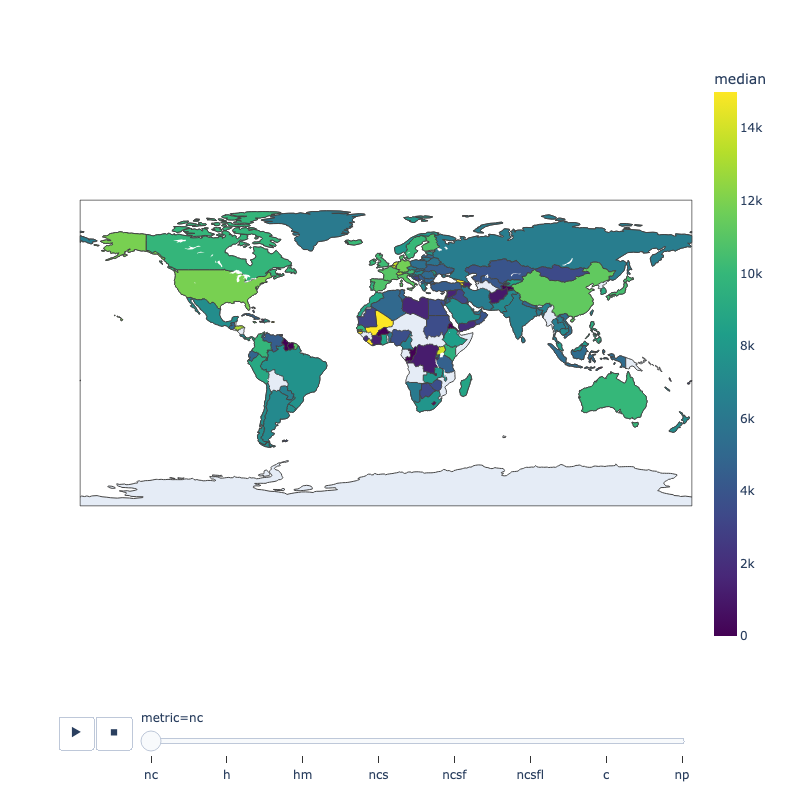

In [119]:
import pandas as pd 
import country_converter as coco
import json
import plotly.io as pio

cc = coco.CountryConverter()
world_path = '../aggregate/custom.geo.json'
with open(world_path) as f: geo_world = json.load(f)
aa = pd.read_pickle('../cntry_sum.pkl')
yr = 2021
log = ''
st_idx = 3
metrics = ['nc', 'h', 'hm',  'ncs', 'ncsf', 'ncsfl', 'c', 'np']
metrics_name = ['# Citations', 'H-index', 'Hm-index',  '# citations to single auth papers', '# citations to single/first auth papers', '# citations to single/first/last auth papers', 'Composite score', 'Number of papers']
df = pd.DataFrame(columns=['code', 'country', 'median', 'min','geometry', 'metric', 'metric_name'])
kk = 0
for idxx, metric in enumerate(metrics):
    for idx, cntry in enumerate(aa):
        if cntry['ct'] != 'csk' and cntry['ct'] != 'nan':
            if cntry['ct'] == 'sux':
                cur_name = "Russia"
            elif cntry['ct'] == 'ant': 
                cur_name = "Netherlands"
            elif cntry['ct'] == 'scg': 
                cur_name = 'Czech Republic'
            else: 
                cur_name = cc.convert(cntry['ct'], to = 'name_short')
            try:
                df.loc[kk] = ([cntry['ct'].upper()]) + [cur_name] + [cntry['dat'][f'career_{yr}{log}'][metric][3]] + [cntry['dat'][f'career_{yr}{log}'][metric][3]] + [''] + [str(metric)] + [str(metrics_name[idxx])]
            except Exception as e:
                df.loc[kk] = ([cntry['ct'].upper()]) + [cur_name] + [0]+ [0] + [''] + [str(metric)] + ['lel']
            kk = kk +1 

df.index = df['code']


import plotly.express as px

# fig = px.choropleth_mapbox(data_frame=df,
#                            geojson=geo_world_ok,
#                            locations='code',
#                            color='median',
#                            color_continuous_scale="viridis",
#                            mapbox_style = 'open-street-map',
#                            #range_color=(0, 50),
#                            animation_frame='metric',
#                            hover_data=['country','metric_name'],
#                            zoom = 0.3)

fig = px.choropleth(data_frame=df,
                           locations='code',
                           color='median',
                           color_continuous_scale="viridis",
                           range_color=(0, 15000),
                           animation_frame='metric',
                           hover_data=['country','metric_name'])

fig.update_layout(width=800,
                  height = 800,
                  coloraxis_colorbar_thickness=23) 



In [105]:
'fra' in list(df.code)

True

In [107]:
df[df['code'] == 'fra']

,code,country,median,min,geometry,metric,metric_name
code,,,,,,,
fra,fra,France,10986.500000,10986.500000,,nc,# Citations
fra,fra,France,52.000000,52.000000,,h,H-index
fra,fra,France,21.133815,21.133815,,hm,Hm-index
fra,fra,France,327.250000,327.250000,,ncs,# citations to single auth papers
fra,fra,France,2060.000000,2060.000000,,ncsf,# citations to single/first auth papers
fra,fra,France,4681.250000,4681.250000,,ncsfl,# citations to single/first/last auth papers
fra,fra,France,3.702983,3.702983,,c,Composite score
fra,fra,France,270.000000,270.000000,,np,Number of papers


In [123]:
aa = pd.read_pickle('../cntry_sum.pkl')
bb = pd.read_pickle('../cntry_career.pickle')

In [128]:
aa[0]['dat']['career_2017']

{'np': [5, 99.0, 153.0, 235.0, 2031, 46013],
 'rank (ns)': [2, 21976.0, 46973.0, 74042.0, 317294, 46013],
 'nc (ns)': [323, 3474.0, 5666.0, 10023.0, 241071, 46013],
 'h (ns)': [4, 29.0, 37.0, 48.0, 213, 46013],
 'hm (ns)': [2.0, 14.5728, 17.7167, 22.3595, 95.0833, 46013],
 'nps (ns)': [0, 5.0, 9.0, 18.0, 958, 46013],
 'ncs (ns)': [0, 79.0, 211.0, 500.0, 135334, 46013],
 'cpsf (ns)': [1, 23.0, 35.0, 55.0, 1274, 46013],
 'ncsf (ns)': [17, 854.0, 1343.0, 2238.0, 147569, 46013],
 'npsfl (ns)': [3, 60.0, 92.0, 142.0, 1723, 46013],
 'ncsfl (ns)': [171, 2052.0, 3120.0, 5263.0, 154733, 46013],
 'c (ns)': [2.861693, 3.513474, 3.680695, 3.926044, 5.514069, 46013],
 'npciting (ns)': [286, 2627.0, 4281.0, 7423.0, 170213, 46013],
 'self%': [0.0,
  0.07116502400808689,
  0.10729062633756603,
  0.15164791396992927,
  0.7353152721169983,
  46013],
 'rank': [3, 22614.0, 48357.0, 76338.0, 122864, 46013],
 'nc': [901, 3975.0, 6482.0, 11384.0, 259310, 46013],
 'h': [4, 31.0, 40.0, 52.0, 222, 46013],
 'hm'

In [136]:
list(set([cr.split('_')[1] for cr in list(bb[0]['dat'].keys())]))

['2018', '2021', '2017', '2020', '2019']